**Cleaned version of the gradients file as the last one was getting very messy. Note that at different headers, some notes were written that may be worth revisiting**

In [1]:
%run gradients
%run representation_analysis

# Reward Auxiliary Tasks

## Data Collection

Iterate through different saved checkpoints, simulate collection of trajectories/batches, collect gradients generated by each batch for comparison. For reward auxiliary tasks, the way we compare cosine similarity for auxiliary task is
* (First note that agents are trained fully with reward auxiliary task)
* Compute gradient generated by the full RL + auxiliary reward
* Delete rewards that were associated with reaching the goal (RL rewards), then recompute returns and gradients
* Compare these gradients (RL + aux vs. aux) to calculate cosine similarity

**Note that these gradients are very reward dependent.** The agent during training has rewards that are normalized by the variance of rewards seen, but this reward normalizer was unfortunately not saved. Additionally, turning off reward normalization and training leads to much worse training performance. To combat this, we will "warm up" the reward normalizer prior to collecting gradients in the below code (have the agent experience 128(batchsize)4(processes)50(batches) of steps) before collecting gradients. We continue using this same reward normalizer without further warming up under the assumption that between sved checkpoints performance will not change enough that the normalizer will not be able to adjust through the actually collected 20 batches.

In [ ]:
collect_batch = 128
collect_processes = 4

"""Set up storage object
"""
batch_sizes = [16, 32]
aux_tasks = ['rewexplore', 'rewdist']
trials = range(3)
all_chks = [[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,
        170, 190, 210, 230, 250, 270, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800],
            [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,
        170, 190, 210, 230, 250, 270, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900]]


all_res = {}

for i, batch in enumerate(batch_sizes):
    all_res[batch] = {}
    for aux in aux_tasks:
        all_res[batch][aux] = {}
        for trial in trials:
            all_res[batch][aux][trial] = {}
            
            

for i, batch in enumerate(batch_sizes):
    for aux in aux_tasks:
        for trial in trials:
            exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}_t{trial}'

            chk_path = Path('../trained_models/checkpoint/')/exp_name
            chks = all_chks[i]
            

            #Load first checkpoint and warm up reward normalization
            model, obs_rms = torch.load(chk_path/f'{chks[0]}.pt')
            agent, envs, storage = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs, num_steps=collect_batch,
                                                    num_processes=collect_processes, ppo_epoch=1, take_optimizer_step=False, normalize=True)
            obs = storage.obs[0].clone()
            res = collect_batches_and_grads(agent, envs, storage, 50)


            cs_means = []
            for chk in tqdm(chks):
                model, obs_rms = torch.load(chk_path/f'{chk}.pt')
                obs = storage.obs[-1].clone()
                envs.venv.obs_rms = obs_rms
                agent, _, storage = initialize_ppo_training(model, obs_rms, env_kwargs=env_kwargs, num_steps=collect_batch,
                                                        num_processes=collect_processes, ppo_epoch=1, take_optimizer_step=False, normalize=True,
                                                        make_env=False, obs=obs)


                res = collect_batches_and_auxrew_grads(agent, envs, storage, num_batches=20,
                                                      data_callback=nav_data_callback, compute_pure_bonus=True)
                all_res[batch][aux][trial][chk] = res

        pickle.dump(all_res, open(f'data/grads/new_batch{batch}auxrew_grads', 'wb'))


## Cosine Similarity Computations

Calculate cosine similarities and save them as **all_xs, all_ys** for the checkpoint vs cos sim plot, and **all_batch_ordered_cs** for the combo color plots

In [ ]:
batch_sizes = [16, 32]
trials = range(3)

all_chks = {16: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,
        170, 190, 210, 230, 250, 270, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800],
            32: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,
        170, 190, 210, 230, 250, 270, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900]}

aux_tasks = ['rewdist', 'rewexplore']

#all_batch_ordered_cs used to hold all cos sims for summary plots
all_batch_ordered_cs = {}
#all_xs, all_ys used for plotting cos sim over training checkpoints
all_xs = defaultdict(dict)
all_ys = defaultdict(dict)

for i, batch in enumerate(tqdm(batch_sizes)):
    all_batch_ordered_cs[batch] = {}
    for j, aux in enumerate(aux_tasks):
        all_batch_ordered_cs[batch][aux] = {}
        xs = []
        ys = []

        for trial in trials:
            all_batch_ordered_cs[batch][aux][trial] = {}
            chk_res = all_res[batch][aux][trial]
            chks = all_chks[batch]
            
            x = []
            y = []

            for _, chk in enumerate(chks):
                res = chk_res[chk]
                # cs = cos_sim_grad(res['all_grads_bonus'], res['all_grads_pure_bonus'], pairwise=False)    
                # batch_ordered_cs = np.array(cs).reshape(len(res['all_grads_goal']), -1).mean(axis=0)
                
                # Using only actor layers
                cs = cos_sim_grad(res['all_grads_bonus'], res['all_grads_pure_bonus'], pairwise=False,
                                 use_layer_subset='a')    
                batch_ordered_cs = np.array(cs).reshape(4, -1).mean(axis=0)
                
                x.append(chk)
                y.append(np.mean(cs))
                all_batch_ordered_cs[batch][aux][trial][chk] = list(batch_ordered_cs)
                
            xs.append(x)
            ys.append(y)
        
        all_xs[batch][aux] = xs
        all_ys[batch][aux] = ys

        

## Plots

### Performance vs. Cosine Similarity

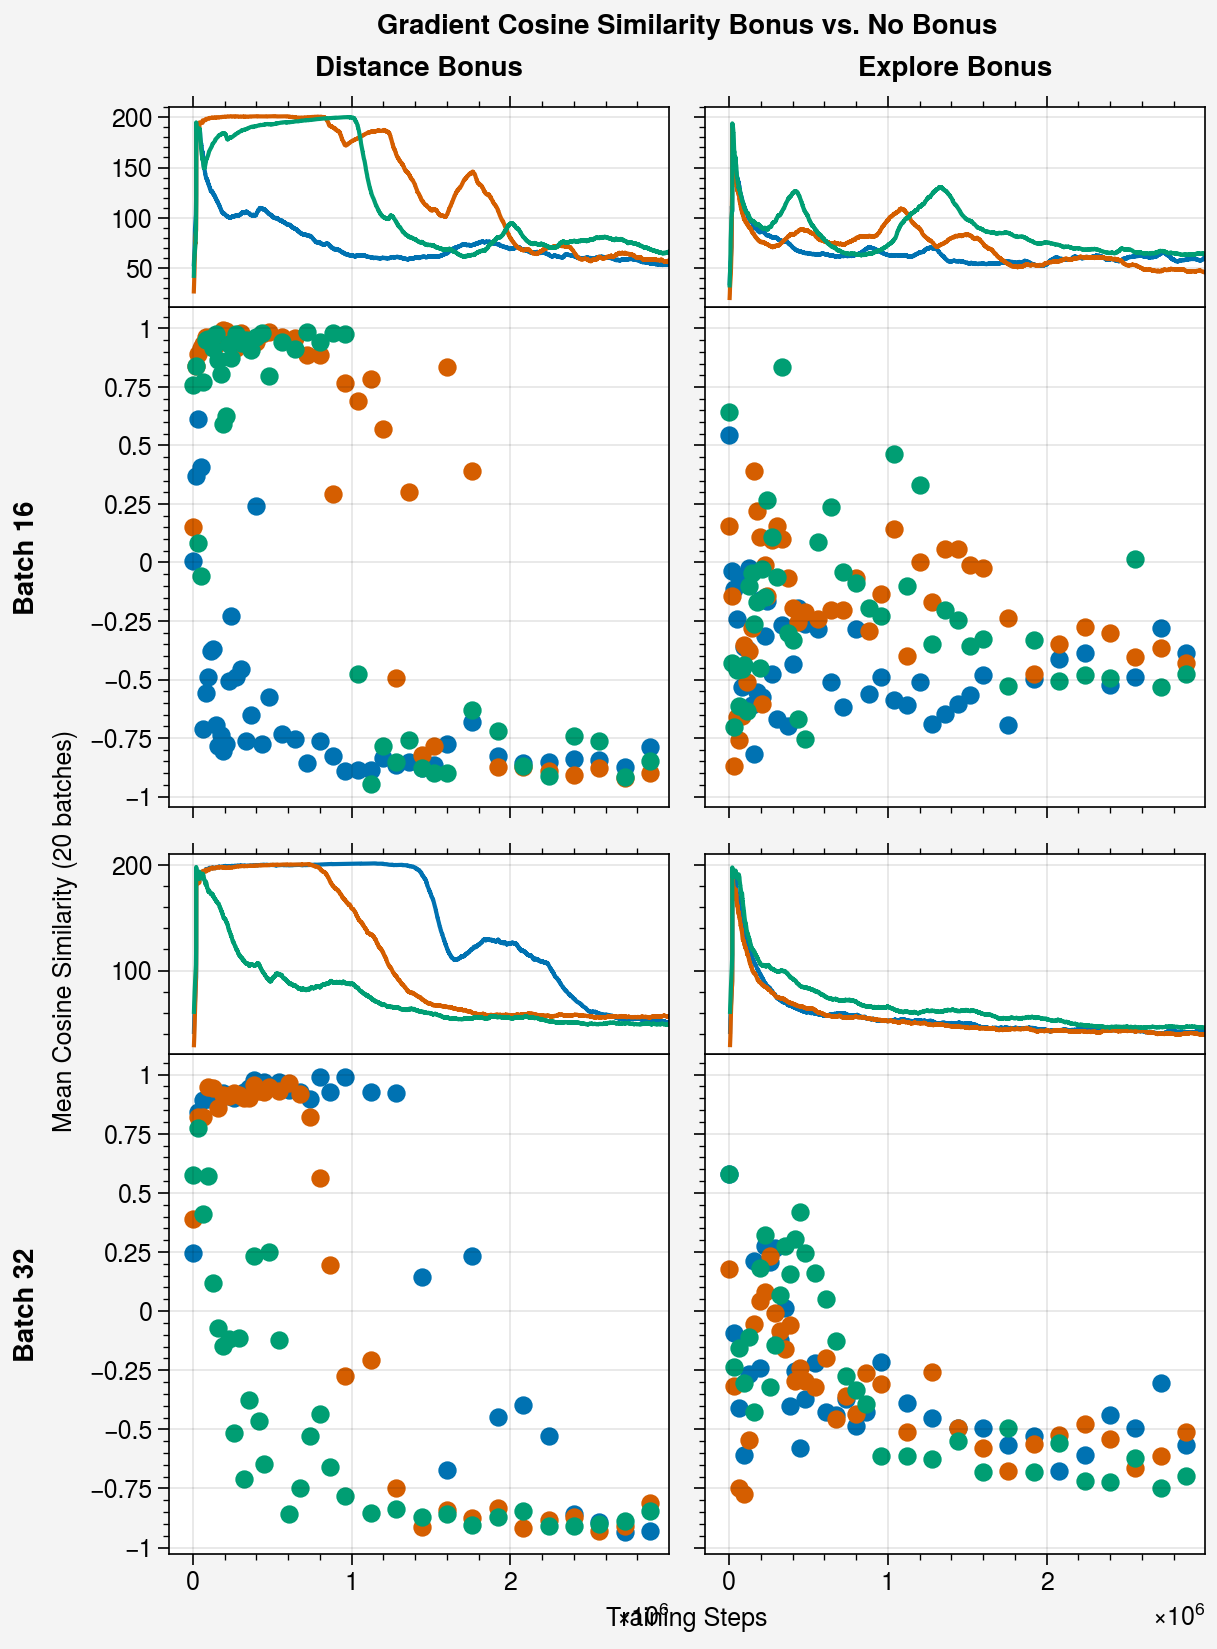

In [92]:
fig, ax = pplt.subplots(nrows=2, ncols=2)
tax = ax.panel_axes('t', space=0, width=1)

aux_labels = ['Distance Bonus', 'Explore Bonus']

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        xs = all_xs[batch][aux]
        ys = all_ys[batch][aux]
        
        exp_name = f'nav_pdistal_batchaux/nav_pdistal_batch{batch}aux{aux}'
        t_xs, t_ys, _, _ = average_runs(exp_name, 'length', ignore_first=100,
                                            ewm=0.001, ret=True)
        for t in trials:
            x = xs[t]
            y = ys[t]
            x = np.array(x) * batch * 100
            
            ax[i, j].scatter(x, y)
            tax[i, j].plot(t_xs, t_ys[t])
            
ax.format(leftlabels=[f'Batch {batch}' for batch in batch_sizes],
          toplabels=aux_labels, suptitle='Gradient Cosine Similarity Bonus vs. No Bonus',
          xlabel='Training Steps', ylabel='Mean Cosine Similarity (20 batches)')

### Individual agent cosine similarities through training, colored by number of goal rewards earned in a batch

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.52it/s]


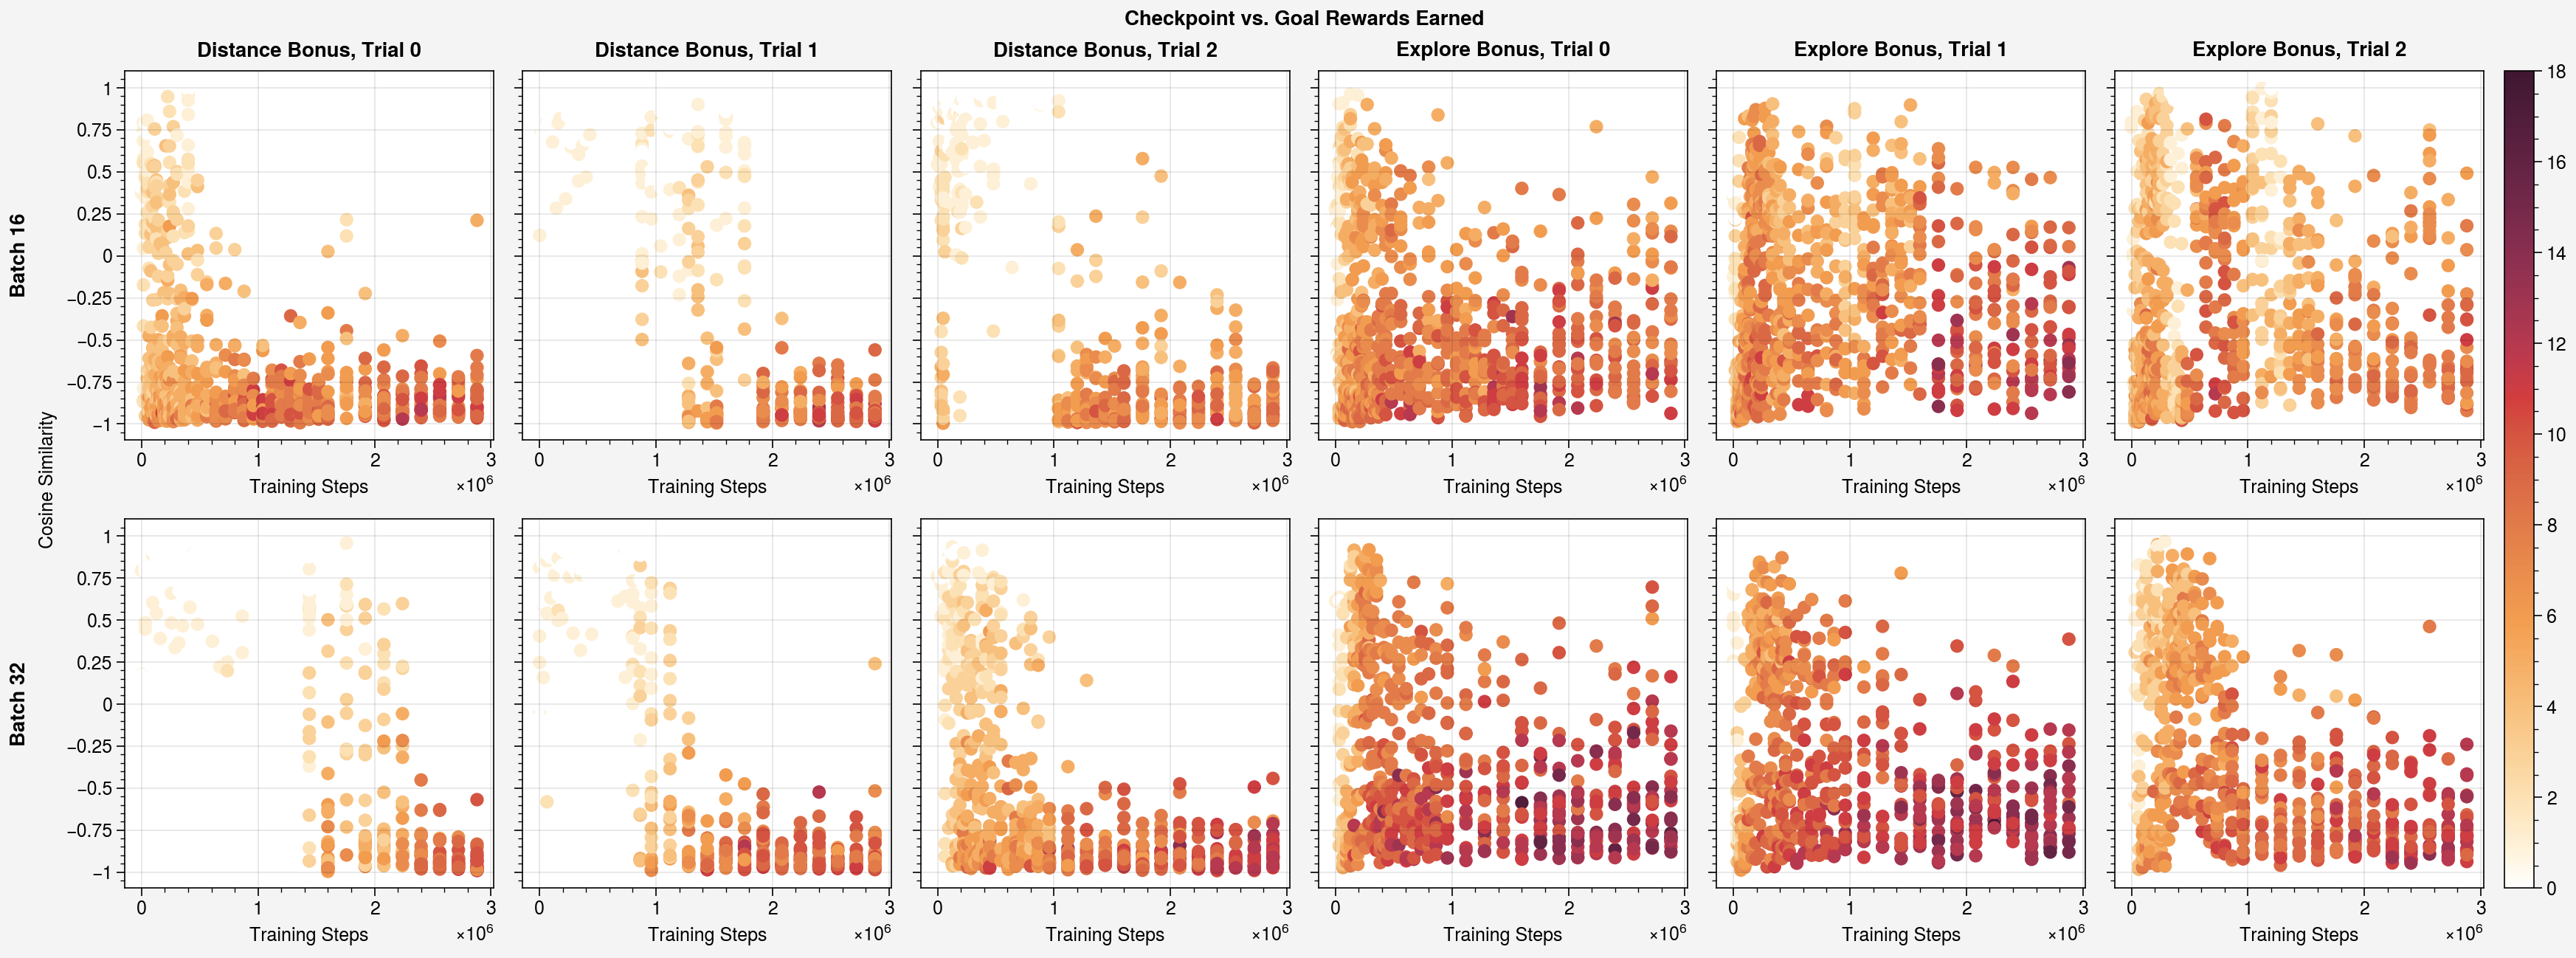

In [93]:
fig, ax = pplt.subplots(nrows=2, ncols=6, sharex=False)

aux_labels = ['Distance Bonus', 'Explore Bonus']
# Get color ranges for shared colorbar
all_cs = []
for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        for trial in trials:
            for chk in chks:
                res = all_res[batch][aux][trial][chk]
                for rew in res['all_rewards_bonus']:
                    all_cs.append(len(rew[rew > 1]))
                
vmin = min(all_cs)
vmax = max(all_cs)

for i, batch in enumerate(tqdm(batch_sizes)):
    for j, aux in enumerate(aux_tasks):
        for trial in trials:
            chk_res = all_res[batch][aux][trial]
            chks = all_chks[batch]
            xs = []
            ys = []
            cs = []
            for chk in chks:
                res = chk_res[chk]
                xs += [chk*batch*100]*(len(batch_ordered_cs))
                batch_ordered_cs = all_batch_ordered_cs[batch][aux][trial][chk]
                ys += batch_ordered_cs
                
                for rew in res['all_rewards_bonus']:
                    cs.append(len(rew[rew > 1]))
                
            scatter = ax[i, j*3+trial].scatter(xs, ys, c=cs, vmin=vmin, vmax=vmax)

fig.colorbar(scatter)
toplabels = []
for label in aux_labels:
    for i in range(3):
        toplabels.append(f'{label}, Trial {i}')
ax.format(suptitle='Checkpoint vs. Goal Rewards Earned',
         leftlabels=[f'Batch {batch}' for batch in batch_sizes],
         toplabels=toplabels, xlabel='Training Steps', ylabel='Cosine Similarity')

### Summary of aux reward cosine similarities vs. RL rewards earned

It was apparent from the above two plots that as we earned more goal rewards, cosine simmilarity dropped. This makes sense based on the way we collect gradients, where the better the agent performance, the more gradients will be driven primarily by the RL task. Hence a better trained agent has a larger cosine distance between RL + aux grad and aux grad (as compared to a less trained agent where the RL + aux grad has less RL contribution)

However, it is also clear that the distance bonus auxiliary task has significantly more cosine distance once RL performance increases. The explore bonus on the other hand has more batches where there were both a large number of rewards collected (5-10) and still had good cosine similarity.

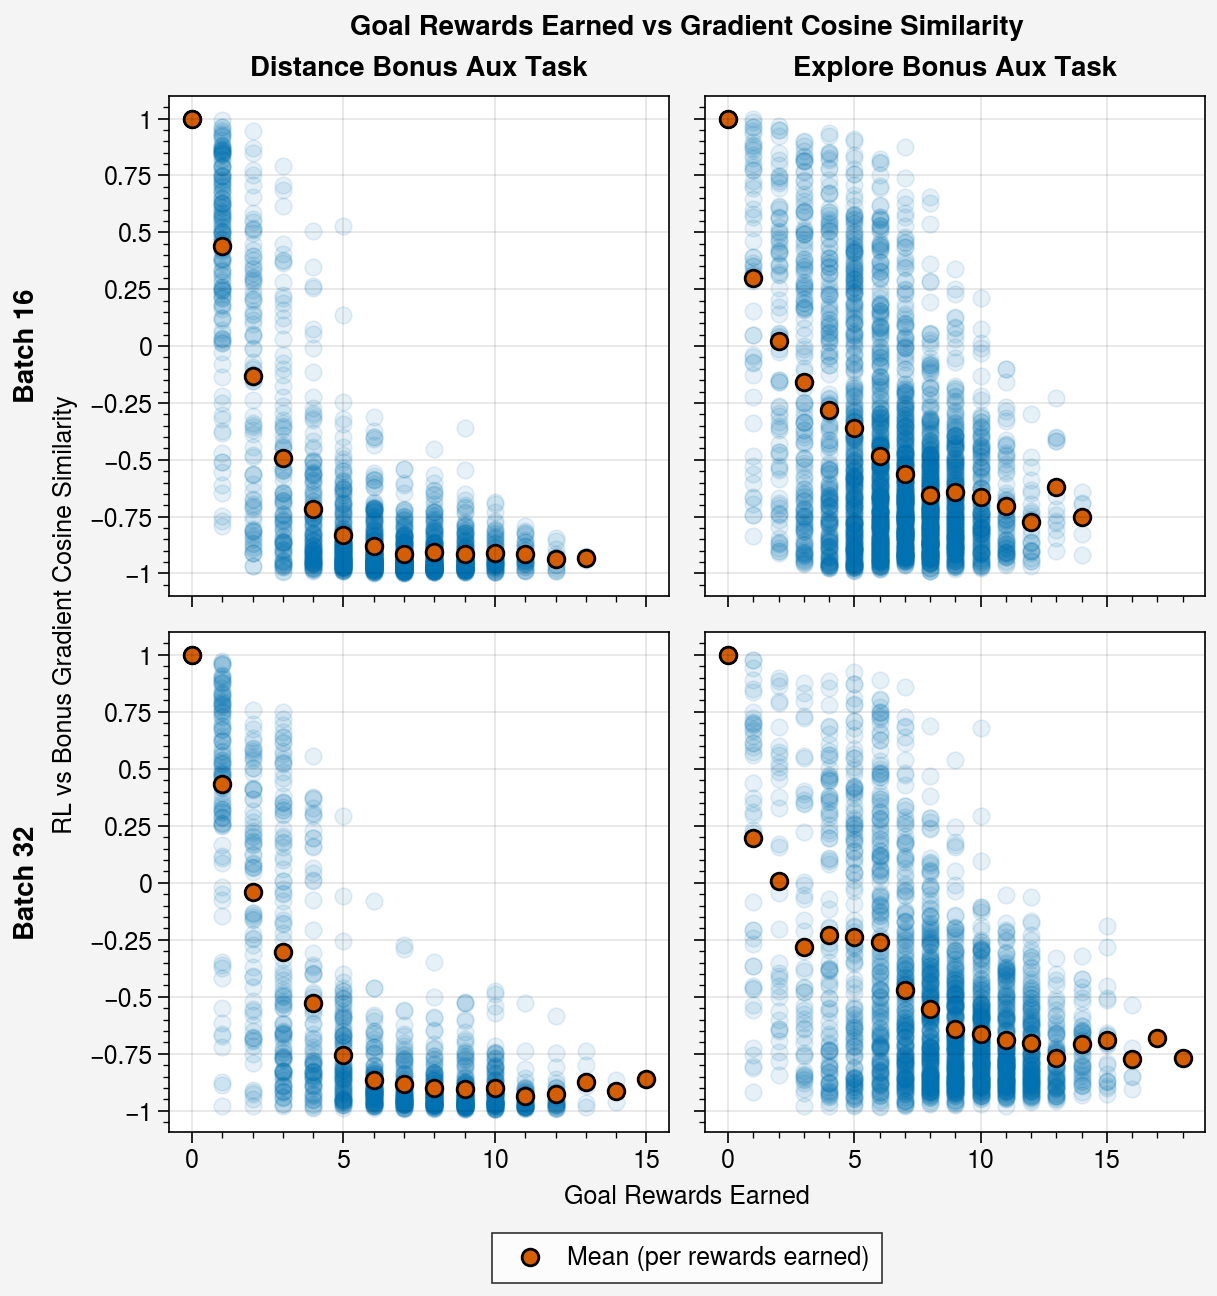

In [125]:
fig, ax = pplt.subplots(nrows=2, ncols=2, sharex=True)

all_xs = defaultdict(list)
all_ys = defaultdict(list)

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        for trial in trials:
            chks = all_chks[batch]
            xs = []
            ys = []
            cs = []
            for chk in chks:
                res = all_res[batch][aux][trial][chk]
                batch_ordered_cs = all_batch_ordered_cs[batch][aux][trial][chk]
                # rew_bonus = np.array([r.sum().item() for r in res['all_rewards_bonus']])
                # rew_goal = np.array([r.sum().item() for r in res['all_rewards_goal']])
                # xs.append(np.mean(rew_bonus - rew_goal))
                
                for rew in res['all_rewards_bonus']:
                    xs.append(len(rew[rew > 1]))
                # rew = res['all_rewards_bonus'][0]
                # xs.append(len(rew[rew > 1]))
                # ys.append(np.mean(batch_ordered_cs))
                ys += batch_ordered_cs
            all_xs[f'batch{batch}aux{aux}'].append(xs)
            all_ys[f'batch{batch}aux{aux}'].append(ys)
            
            
                

for i, batch in enumerate(batch_sizes):
    for j, aux in enumerate(aux_tasks):
        key = f'batch{batch}aux{aux}'
        x = np.concatenate(all_xs[key])
        y = np.concatenate(all_ys[key])
        
        lr = LinearRegression()
        lr.fit(x.reshape(-1, 1), y)
        y_pred = lr.predict(x.reshape(-1, 1))
        xline = np.array([[min(x)],[max(x)]])
        yline = lr.predict(xline)
        xline, yline = xline.squeeze(), yline.squeeze()
        
        
        r2 = np.corrcoef(x, y)[0,1]**2
        mse = mean_squared_error(y, y_pred)

        x_means = []
        y_means = []
        y_medians = []
        for x_i in np.unique(x):
            x_means.append(x_i)
            y_means.append(y[x == x_i].mean())
            y_medians.append(np.median(y[x == x_i]))
        
        ax[i, j].scatter(x, y, alpha=0.1)
        scatters = [ax[i, j].scatter(x_means, y_means, edgecolor='black', linewidth=1,
                        label='mean')]
fig.legend(scatters, 'Mean (per rewards earned)', loc='b')
        
        
ax.format(suptitle='Goal Rewards Earned vs Gradient Cosine Similarity',
          xlabel='Goal Rewards Earned', ylabel='RL vs Bonus Gradient Cosine Similarity',
         toplabels=['Distance Bonus Aux Task', 'Explore Bonus Aux Task'], leftlabels=['Batch 16',  'Batch 32'])


# Toy Example of Rew Aux Grad Similarities

In this toy example, we have 2 possible states (green light, red light) and 3 possible actions (go, do nothing, stop). We give a reward of 1 in correct responses (green light - go, red light - stop), a reward of -1 for incorrect responses, and 0 for taking the "do nothing" action

For each action, the policy "network" has a parameter w_i, so the probability of taking an action is $$\pi(a_k | s) = \frac{e^{w_k s}}{\sum_i e^{w_i s}}$$

We initialize a weight vector of w = [0.3, 0.1, -0.4], and an optimal policy will be given as long as $$w_1 >> w_2 >> w_3$$. From the weight vector we can compute true V so no need for function approximation in this case. 

We collect some "trajectories" (3 steps each), and give auxiliary rewards. We have a beneficial and non-beneficial task. We can compute the advantages and sum the gradients induced by the trajectories. Additionally, if we remove the "RL task" rewards and only keep the bonus ones, we can see the summed gradient induced by this as well, and finally calculate the cosine similarity between the two gradients

**First Example "Beneficial"**

We give a bonus 0.1 reward when s=1 and a=1, which is the action that is desirable at this state. Observe cosine similarity of 0.74

In [89]:
w = torch.tensor([0.3, 0.1, -0.4], requires_grad=True)

#Trajectories Set 1 (bonus on s1a1)
s_traj = [1, -1, 1]
a_traj = [1, 1, -1]
r_traj = [1.1, -1, -1]
r_bonus_traj = [0.1, 0, 0]

# # Trajectories Set 2 (bonus on a0)
# s_traj = [1, -1, 1]
# a_traj = [1, 0, -1]
# r_traj = [1, 0.1, -1]
# r_bonus_traj = [0, 0.1, 0]


pi1 = torch.exp(w*1) / (torch.sum(torch.exp(w*1)))
pi2 = torch.exp(w*-1) / (torch.sum(torch.exp(w*-1)))
r1 = torch.tensor([1.1, 0., -1.])
r2 = torch.tensor([-1., 0., 1.])
v1 = torch.dot(pi1, r1).detach().item()
v2 = torch.dot(pi2, r2).detach().item()

w.grad = torch.zeros(3)
print('Computing Full Grad')
for s, a, r in zip(s_traj, a_traj, r_traj):
    if s == 1:
        adv = r - v1
    else:
        adv = r - v2
        
    pi = torch.exp(w*s) / (torch.sum(torch.exp(w*s)))
        
    if a == 1:
        a_idx = 0
    elif a == 0:
        a_idx = 1
    elif a == -1:
        a_idx = 2
    
    print(f'Advantage: ', adv)
    
    (pi[a_idx] * adv).backward()
g1 = w.grad.numpy()
print('Full Grad: ', g1, '\n')

w.grad = torch.zeros(3)
print('Computing Bonus Only Grad')
for s, a, r in zip(s_traj, a_traj, r_bonus_traj):
    if s == 1:
        adv = r - v1
    else:
        adv = r - v2
        
    pi = torch.exp(w*s) / (torch.sum(torch.exp(w*s)))
        
    if a == 1:
        a_idx = 0
    elif a == 0:
        a_idx = 1
    elif a == -1:
        a_idx = 2
    
    print(f'Advantage: ', adv)
    
    (pi[a_idx] * adv).backward()
g2 = w.grad.numpy()
print('Bonus Only Grad: ', g2, '\n')

print('Cosine Similarity: ', cosine_similarity(g1.reshape(1, -1), 
                                               g2.reshape(1, -1)).squeeze())

    
    

Computing Full Grad
Advantage:  0.8393812537193299
Advantage:  -1.2393661588430405
Advantage:  -1.2606187462806702
Full Grad:  [ 0.54627067 -0.11698432 -0.42928636] 

Computing Bonus Only Grad
Advantage:  -0.16061874628067016
Advantage:  -0.23936615884304047
Advantage:  -0.26061874628067017
Bonus Only Grad:  [ 0.02790606  0.02799731 -0.05590338] 

Cosine Similarity:  0.7456216


**Second Example "Harmful"**

In this task, we give the agent a bonus of 0.1 reward whenever the "do nothing" action is taken. Performing the same routine, the bonus only gradient and the full gradient (RL + auxiliary) have fairly dissimilar directions (-0.004 cosine similarity)

In [165]:
w = torch.tensor([0.3, 0.1, -0.4], requires_grad=True)

# #Trajectories Set 1 (bonus on s1a1)
# s_traj = [1, -1, 1]
# a_traj = [1, 1, -1]
# r_traj = [1.1, -1, -1]
# r_bonus_traj = [0.1, 0, 0]

# Trajectories Set 2 (bonus on a0)
s_traj = [1, -1, 1]
a_traj = [1, 0, -1]
r_traj = [1, 0.1, -1]
r_bonus_traj = [0, 0.1, 0]


pi1 = torch.exp(w*1) / (torch.sum(torch.exp(w*1)))
pi2 = torch.exp(w*-1) / (torch.sum(torch.exp(w*-1)))
r1 = torch.tensor([1., 0.1, -1.])
r2 = torch.tensor([-1., 0.1, 1.])
v1 = torch.dot(pi1, r1).detach().item()
v2 = torch.dot(pi2, r2).detach().item()
print(f'V(1) = {v1}, V(-1) = {v2}')

w.grad = torch.zeros(3)
print('Computing Full Grad')
for s, a, r in zip(s_traj, a_traj, r_traj):
    if s == 1:
        adv = r - v1
    else:
        adv = r - v2
        
    pi = torch.exp(w*s) / (torch.sum(torch.exp(w*s)))
        
    if a == 1:
        a_idx = 0
    elif a == 0:
        a_idx = 1
    elif a == -1:
        a_idx = 2
    
    print(f'Advantage: ', adv)
    
    (pi[a_idx] * adv).backward()
g1 = w.grad.numpy()
print('Full Grad: ', g1, '\n')

w.grad = torch.zeros(3)
print('Computing Bonus Only Grad')
for s, a, r in zip(s_traj, a_traj, r_bonus_traj):
    if s == 1:
        adv = r - v1
    else:
        adv = r - v2
        
    pi = torch.exp(w*s) / (torch.sum(torch.exp(w*s)))
        
    if a == 1:
        a_idx = 0
    elif a == 0:
        a_idx = 1
    elif a == -1:
        a_idx = 2
    
    print(f'Advantage: ', adv)
    
    (pi[a_idx] * adv).backward()
g2 = w.grad.numpy()
print('Bonus Only Grad: ', g2, '\n')

print('Cosine Similarity: ', cosine_similarity(g1.reshape(1, -1), 
                                               g2.reshape(1, -1)).squeeze())

    
    

V(1) = 0.25278955698013306, V(-1) = 0.26820576190948486
Computing Full Grad
Advantage:  0.7472104430198669
Advantage:  -0.16820576190948486
Advantage:  -1.252789556980133
Full Grad:  [ 0.28793555  0.01541445 -0.30335   ] 

Computing Bonus Only Grad
Advantage:  -0.25278955698013306
Advantage:  -0.16820576190948486
Advantage:  -0.25278955698013306
Bonus Only Grad:  [-0.05006232  0.0923003  -0.042238  ] 

Cosine Similarity:  -0.0037802476


In [172]:
'''
Modifiable
s_traj: collection of [s1, s2, s3] (states that were "collected")
a_traj: collection of [a1, a2, a3] (actions that were "taken")
r1, r2: rewards given for each action under "green" and "red" light
r1_bonus, r2_bonus: auxiliary rewards for each action under "green" and "red" light
'''

w = torch.tensor([0.3, 0.1, -0.4], requires_grad=True)

# #Trajectories Set 1
# s_traj = [1, -1, 1]
# a_traj = [1, 1, -1]

# Trajectories Set 2
# 
s_traj = [1, -1, 1]
a_traj = [1, 0, -1]

# Set rewards for each action. r1 are the rewards if state=1, r2 are rewards if state=-1
#   rewards in order of [go, do nothing, stop]
r1 = torch.tensor([1., 0, -1.])
r2 = torch.tensor([-1., 0, 1.])

r1_bonus = torch.tensor([0, 0.1, 0])
r2_bonus = torch.tensor([0, 0.1, 0])


'''
Fixed Computations
'''
r1_total = r1 + r1_bonus
r2_total = r2 + r2_bonus
pi1 = torch.exp(w*1) / (torch.sum(torch.exp(w*1)))
pi2 = torch.exp(w*-1) / (torch.sum(torch.exp(w*-1)))
v1 = torch.dot(pi1, r1_total).detach().item()
v2 = torch.dot(pi2, r2_total).detach().item()

print(f'V(1) = {v1}, V(-1) = {v2}')
w.grad = torch.zeros(3)
print('Computing Full Grad')
for s, a in zip(s_traj, a_traj):
    # Convert actions to indexes
    if a == 1:
        a_idx = 0
    elif a == 0:
        a_idx = 1
    elif a == -1:
        a_idx = 2
        
    if s == 1:
        r = r1_total[a_idx]
        adv = r - v1
    else:
        r = r2_total[a_idx]
        adv = r - v2
    adv = adv.item()
    pi = torch.exp(w*s) / (torch.sum(torch.exp(w*s)))

    print(f'Advantage: ', adv)
    
    # Compute partial derivatives multiplied by advantage
    (pi[a_idx] * adv).backward()
g1 = w.grad
print('Full Grad: ', g1, '\n')

w.grad = torch.zeros(3)
print('Computing Bonus Only Grad')
for s, a, r in zip(s_traj, a_traj, r_bonus_traj):
    # Convert actions to indexes
    if a == 1:
        a_idx = 0
    elif a == 0:
        a_idx = 1
    elif a == -1:
        a_idx = 2
        
    if s == 1:
        r = r1_bonus[a_idx]
        adv = r - v1
    else:
        r = r2_bonus[a_idx]
        adv = r - v2
    adv = adv.item()
    pi = torch.exp(w*s) / (torch.sum(torch.exp(w*s)))
    
    print(f'Advantage: ', adv)
    
    (pi[a_idx] * adv).backward()
g2 = w.grad
print('Bonus Only Grad: ', g2, '\n')

cs = torch.nn.CosineSimilarity(dim=0)
print('Cosine Similarity: ', cs(g1, g2).item())


    

V(1) = 0.25278955698013306, V(-1) = 0.26820576190948486
Computing Full Grad
Advantage:  0.7472104430198669
Advantage:  -0.16820576786994934
Advantage:  -1.2527894973754883
Full Grad:  tensor([ 0.2879,  0.0154, -0.3034]) 

Computing Bonus Only Grad
Advantage:  -0.25278955698013306
Advantage:  -0.16820576786994934
Advantage:  -0.25278955698013306
Bonus Only Grad:  tensor([-0.0501,  0.0923, -0.0422]) 

Cosine Similarity:  -0.0037802457809448242


## Testing influences on toy example

In [ ]:
'''
Modifiable
s_traj: collection of [s1, s2, s3] (states that were "collected")
a_traj: collection of [a1, a2, a3] (actions that were "taken")
r1, r2: rewards given for each action under "green" and "red" light
r1_bonus, r2_bonus: auxiliary rewards for each action under "green" and "red" light
'''

w = torch.tensor([0.3, 0.1, -0.4], requires_grad=True)

# #Trajectories Set 1
# s_traj = [1, -1, 1]
# a_traj = [1, 1, -1]

# Trajectories Set 2
# 
s_traj = [1, -1, 1]
a_traj = [1, 0, -1]

# Set rewards for each action. r1 are the rewards if state=1, r2 are rewards if state=-1
#   rewards in order of [go, do nothing, stop]
r1 = torch.tensor([1., 0, -1.])
r2 = torch.tensor([-1., 0, 1.])

r1_bonus = torch.tensor([0, 0.1, 0])
r2_bonus = torch.tensor([0, 0.1, 0])


'''
Fixed Computations
'''
r1_total = r1 + r1_bonus
r2_total = r2 + r2_bonus
pi1 = torch.exp(w*1) / (torch.sum(torch.exp(w*1)))
pi2 = torch.exp(w*-1) / (torch.sum(torch.exp(w*-1)))
v1 = torch.dot(pi1, r1_total).detach().item()
v2 = torch.dot(pi2, r2_total).detach().item()

print(f'V(1) = {v1}, V(-1) = {v2}')
w.grad = torch.zeros(3)
print('Computing Full Grad')
for s, a in zip(s_traj, a_traj):
    # Convert actions to indexes
    if a == 1:
        a_idx = 0
    elif a == 0:
        a_idx = 1
    elif a == -1:
        a_idx = 2
        
    if s == 1:
        r = r1_total[a_idx]
        adv = r - v1
    else:
        r = r2_total[a_idx]
        adv = r - v2
    adv = adv.item()
    pi = torch.exp(w*s) / (torch.sum(torch.exp(w*s)))

    print(f'Advantage: ', adv)
    
    # Compute partial derivatives multiplied by advantage
    (pi[a_idx] * adv).backward()
g1 = w.grad
print('Full Grad: ', g1, '\n')

w.grad = torch.zeros(3)
print('Computing Bonus Only Grad')
for s, a, r in zip(s_traj, a_traj, r_bonus_traj):
    # Convert actions to indexes
    if a == 1:
        a_idx = 0
    elif a == 0:
        a_idx = 1
    elif a == -1:
        a_idx = 2
        
    if s == 1:
        r = r1_bonus[a_idx]
        adv = r - v1
    else:
        r = r2_bonus[a_idx]
        adv = r - v2
    adv = adv.item()
    pi = torch.exp(w*s) / (torch.sum(torch.exp(w*s)))
    
    print(f'Advantage: ', adv)
    
    (pi[a_idx] * adv).backward()
g2 = w.grad
print('Bonus Only Grad: ', g2, '\n')

cs = torch.nn.CosineSimilarity(dim=0)
print('Cosine Similarity: ', cs(g1, g2).item())


    